## **Import packages and images**


In [ ]:
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.layers import Dense, Flatten, Dropout, RandomZoom, RandomContrast, RandomRotation
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from numpy import asarray
from google.colab import drive
from random import *
from IPython.display import display
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
!pip install split-folders
!pip install Pillow
from PIL import Image
import splitfolders

drive.mount('/content/gdrive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/gdrive


In [ ]:
IMAGE_SIZE = (224,224)
BATCH_SIZE = 32
NUM_EPOCHS = 20

In [ ]:
splitfolders.ratio('/content/gdrive/MyDrive/research_paper_skin_cancer', output="output", seed=1337, ratio=(.8,0.1,0.1))

train_path = 'output/train'
test_path = 'output/test'
val_path = 'output/val'

Copying files: 2109 files [00:34, 60.93 files/s] 


## **Augment testing images**

before augmentation:


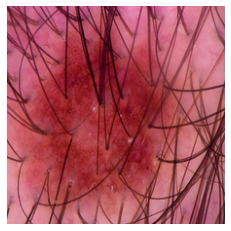

after augmentation:


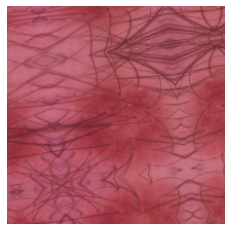

before augmentation:


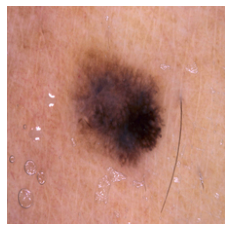

after augmentation:


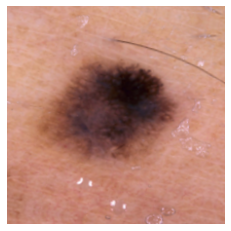

before augmentation:


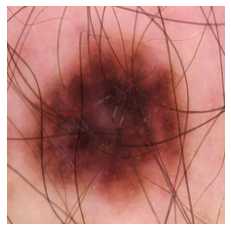

after augmentation:


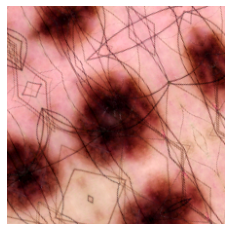

before augmentation:


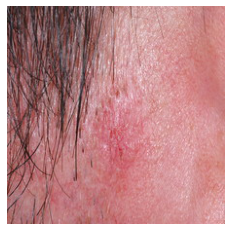

after augmentation:


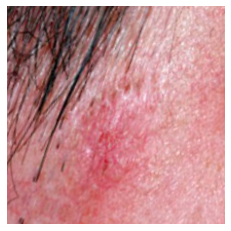

before augmentation:


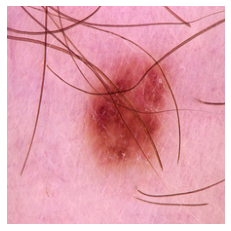

after augmentation:


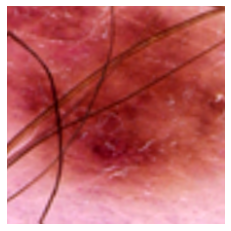

before augmentation:


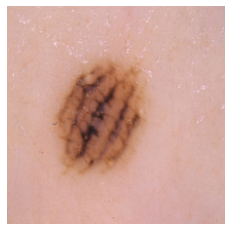

after augmentation:


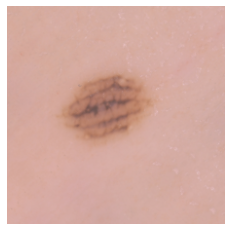

before augmentation:


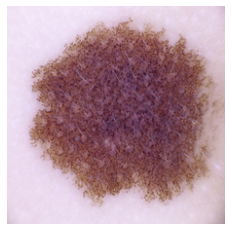

after augmentation:


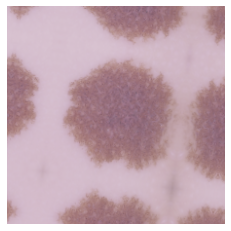

before augmentation:


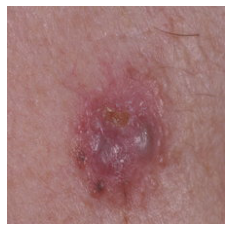

after augmentation:


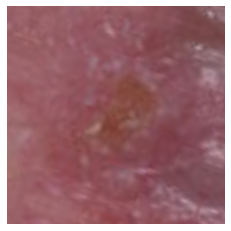

before augmentation:


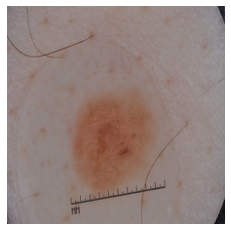

after augmentation:


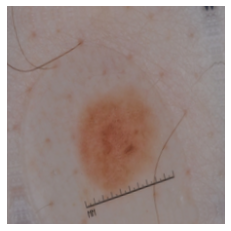

In [ ]:
size_augmentation = RandomZoom(0.8)
contrast_augmentation = RandomContrast(0.6)
rotation_augmentation = RandomRotation(0.3)


def augment_image(np_image):

    num = randint(1, 50)

    if num == 5:
        print('before augmentation:')
        plt.axis('off')
        plt.imshow(np_image)
        plt.show()

    # Random size
    augmented_eager_tensor = size_augmentation(np_image)
    augmented_np_arr = augmented_eager_tensor.numpy()

    # Random contrast
    augmented_eager_tensor = contrast_augmentation(augmented_np_arr)
    augmented_np_arr = augmented_eager_tensor.numpy()

    # Random rotation
    augmented_eager_tensor = rotation_augmentation(augmented_np_arr)
    augmented_np_arr = augmented_eager_tensor.numpy()

    if num == 5:
        print('after augmentation:')
        plt.axis('off')
        plt.imshow(augmented_np_arr / 255)
        plt.show()

    return augmented_np_arr


for folder in os.listdir(test_path):
    sub_path = test_path+'/'+folder
    for img in os.listdir(sub_path):
        pil_img = Image.open(sub_path+'/'+img)
        os.remove(sub_path+'/'+img)
        np_image = asarray(pil_img)
        augmented_arr = augment_image(np_image)

        augmented_image = Image.fromarray(augmented_arr.astype(np.uint8))

        fullpath = os.path.join(sub_path, 'new_' + img)
        augmented_image.save(fullpath)
        

for folder in os.listdir(val_path):
    sub_path = val_path+'/'+folder
    for img in os.listdir(sub_path):
        pil_img = Image.open(sub_path+'/'+img)
        os.remove(sub_path+'/'+img)
        np_image = asarray(pil_img)
        augmented_arr = augment_image(np_image)

        augmented_image = Image.fromarray(augmented_arr.astype(np.uint8))

        fullpath = os.path.join(sub_path, 'new_' + img)
        augmented_image.save(fullpath)

In [ ]:
DATAGEN = ImageDataGenerator(rescale = 1./255, validation_split=0.2)


training_set = DATAGEN.flow_from_directory(train_path,
                                                 target_size = IMAGE_SIZE,
                                                 batch_size = BATCH_SIZE,
                                                 class_mode = 'categorical')

test_set = DATAGEN.flow_from_directory(test_path,
                                            target_size = IMAGE_SIZE,
                                            batch_size = BATCH_SIZE,
                                            class_mode = 'categorical')

val_set = DATAGEN.flow_from_directory(val_path,
                                            target_size = IMAGE_SIZE,
                                            batch_size = BATCH_SIZE,
                                            class_mode = 'categorical')

Found 1686 images belonging to 2 classes.
Found 213 images belonging to 2 classes.
Found 210 images belonging to 2 classes.


## **Initialize VGG19 DCNN model, trained on ImageNet**

In [ ]:
vgg_19 = VGG19(weights='imagenet', include_top=False, input_shape=(224,224,3))

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
set_trainable = False
for layer in vgg_19.layers:
    layer.trainable = False

In [ ]:
model = models.Sequential()

model.add(vgg_19)

model.add(layers.Flatten())

model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.3))

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(2, activation='softmax'))

In [ ]:
model.compile(
  loss = 'categorical_crossentropy',
  optimizer = optimizers.Adam(lr=2e-5),
  metrics = ['acc']
)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = model.fit(
  training_set,
  steps_per_epoch = training_set.samples // BATCH_SIZE,
  epochs = NUM_EPOCHS,
  validation_data = val_set,
  validation_steps = val_set.samples // BATCH_SIZE,
  shuffle = True
  )

Epoch 1/20
52/52 [==============================] - 23s 245ms/step - loss: 0.6743 - acc: 0.5919 - val_loss: 0.6479 - val_acc: 0.6302
Epoch 2/20
52/52 [==============================] - 11s 204ms/step - loss: 0.5738 - acc: 0.7104 - val_loss: 0.6131 - val_acc: 0.6354
Epoch 3/20
52/52 [==============================] - 11s 207ms/step - loss: 0.5089 - acc: 0.7630 - val_loss: 0.7078 - val_acc: 0.6094
Epoch 4/20
52/52 [==============================] - 11s 213ms/step - loss: 0.4663 - acc: 0.8065 - val_loss: 0.7223 - val_acc: 0.6094
Epoch 5/20
52/52 [==============================] - 11s 219ms/step - loss: 0.4568 - acc: 0.7999 - val_loss: 0.6758 - val_acc: 0.6354
Epoch 6/20
52/52 [==============================] - 11s 217ms/step - loss: 0.4326 - acc: 0.8192 - val_loss: 0.7361 - val_acc: 0.6250
Epoch 7/20
52/52 [==============================] - 11s 218ms/step - loss: 0.4262 - acc: 0.8162 - val_loss: 0.6584 - val_acc: 0.6458
Epoch 8/20
52/52 [==============================] - 11s 211ms/step - 

## **Plot accuracy before Transfer Learning**

In [ ]:
def plot_acc_loss(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

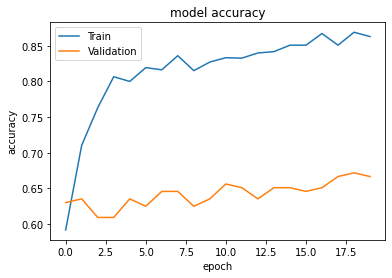

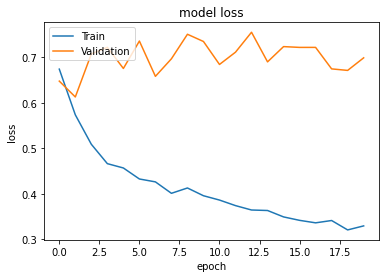

In [ ]:
plot_acc_loss(history)

In [ ]:
test_loss, test_acc = model.evaluate(test_set, steps=test_set.samples // BATCH_SIZE)
print(f"Test Accuracy before fine tuning: {test_acc*100:.2f} %")

6/6 [==============================] - 1s 184ms/step - loss: 0.7265 - acc: 0.6927
Test Accuracy before fine tuning: 69.27 %


## **Fine-tune hyperparameters to optimize performance**

In [ ]:
vgg_19.trainable = True

set_trainable = False
for layer in vgg_19.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable == True:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
model.compile(
  loss = 'categorical_crossentropy',
  optimizer = optimizers.Adam(lr=2e-5),
  metrics = ['acc']
)

In [ ]:
history = model.fit(
  training_set,
  steps_per_epoch = training_set.samples // BATCH_SIZE,
  epochs = NUM_EPOCHS,
  validation_data = val_set,
  validation_steps = val_set.samples // BATCH_SIZE,
  shuffle = True
  )

Epoch 1/20
52/52 [==============================] - 15s 254ms/step - loss: 0.3319 - acc: 0.8543 - val_loss: 0.7128 - val_acc: 0.6615
Epoch 2/20
52/52 [==============================] - 13s 250ms/step - loss: 0.2595 - acc: 0.8839 - val_loss: 0.6160 - val_acc: 0.6875
Epoch 3/20
52/52 [==============================] - 13s 250ms/step - loss: 0.2258 - acc: 0.9105 - val_loss: 0.7200 - val_acc: 0.6510
Epoch 4/20
52/52 [==============================] - 13s 238ms/step - loss: 0.1881 - acc: 0.9281 - val_loss: 1.0208 - val_acc: 0.6354
Epoch 5/20
52/52 [==============================] - 12s 238ms/step - loss: 0.1515 - acc: 0.9407 - val_loss: 1.0614 - val_acc: 0.6771
Epoch 6/20
52/52 [==============================] - 13s 249ms/step - loss: 0.1406 - acc: 0.9474 - val_loss: 0.7868 - val_acc: 0.7135
Epoch 7/20
52/52 [==============================] - 13s 251ms/step - loss: 0.1254 - acc: 0.9541 - val_loss: 1.0862 - val_acc: 0.6823
Epoch 8/20
52/52 [==============================] - 13s 239ms/step - 

## **Plot accuracy after Transfer Learning**

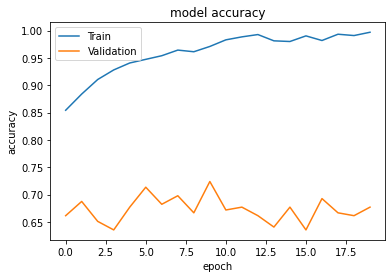

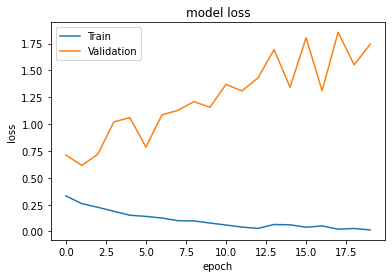

In [ ]:
plot_acc_loss(history)

In [ ]:
test_loss, test_acc = model.evaluate(test_set, steps=test_set.samples // BATCH_SIZE)
print(f"Test Accuracy After fine tuning: {test_acc*100:.2f} %")

6/6 [==============================] - 1s 187ms/step - loss: 2.0172 - acc: 0.6667
Test Accuracy After fine tuning: 66.67 %
